In [1]:
import nibabel as nib 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from skimage.metrics import mean_squared_error as mse
from scipy.spatial.distance import jensenshannon
import pandas as pd
from tqdm import tqdm
from math import log10
from scipy.stats import entropy
from scipy.interpolate import make_interp_spline
from scipy.stats import rankdata
from ridgeplot import ridgeplot
import ptitprince as pt
from scipy.stats import wilcoxon, ranksums, mannwhitneyu

In [2]:
def kl_div(dist1, dist2):
    dist1_hist, dist1_bins = np.histogram(dist1, bins = 10, density = True)
    dist2_hist, dist2_bins = np.histogram(dist2, bins = 10, density = True)
    
    kl = entropy(dist1_hist, dist2_hist)
    return kl

In [3]:
mse_b50ftob30f = {}
mse_bonetostd = {}
kl_bonetob30f = {}
kl_stdtob30f = {}

#Real values
b30f = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/B30f_B50f/soft/emphysema_masked/emph.csv")
b30f = b30f.sort_values(by = "pid")
b50f = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/B30f_B50f/hard/emphysema_masked/emph.csv")
b50f = b50f.sort_values(by = "pid")
bone = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/STANDARD_BONE/hard/emphysema/emph.csv")
bone = bone.sort_values(by = "pid")
std = pd.read_csv("/nfs/masi/krishar1/Kernel_conversion_outputs/TEST/data.application/STANDARD_BONE/soft/emphysema/emph.csv")
std = std.sort_values(by = "pid")

In [4]:
for i in tqdm(range(2,102,2)):
    b50ftob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "B50ftoB30f_emphysema", "emph.csv"))
    b50ftob30f = b50ftob30f.sort_values(by = "pid")
    bonetob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "BONEtoB30f_emphysema", "emph.csv"))
    bonetob30f = bonetob30f.sort_values(by = "pid")
    stdtob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "STDtoB30f_emphysema", "emph.csv"))
    stdtob30f = stdtob30f.sort_values(by = "pid")
    bonetostd = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_" + str(i), "BONEtoSTD_emphysema", "emph.csv"))
    bonetostd = bonetostd.sort_values(by = "pid")

    kl_bonetob30f[i] = kl_div(bonetob30f["emph_score"].values, b30f["emph_score"].values)
    kl_stdtob30f[i] = kl_div(stdtob30f["emph_score"].values, b30f["emph_score"].values)
    mse_b50ftob30f[i] = mse(b50ftob30f["emph_score"].values, b30f["emph_score"].values)
    mse_bonetostd[i] = mse(bonetostd["emph_score"].values, std["emph_score"].values)

100%|██████████| 50/50 [00:00<00:00, 57.17it/s]


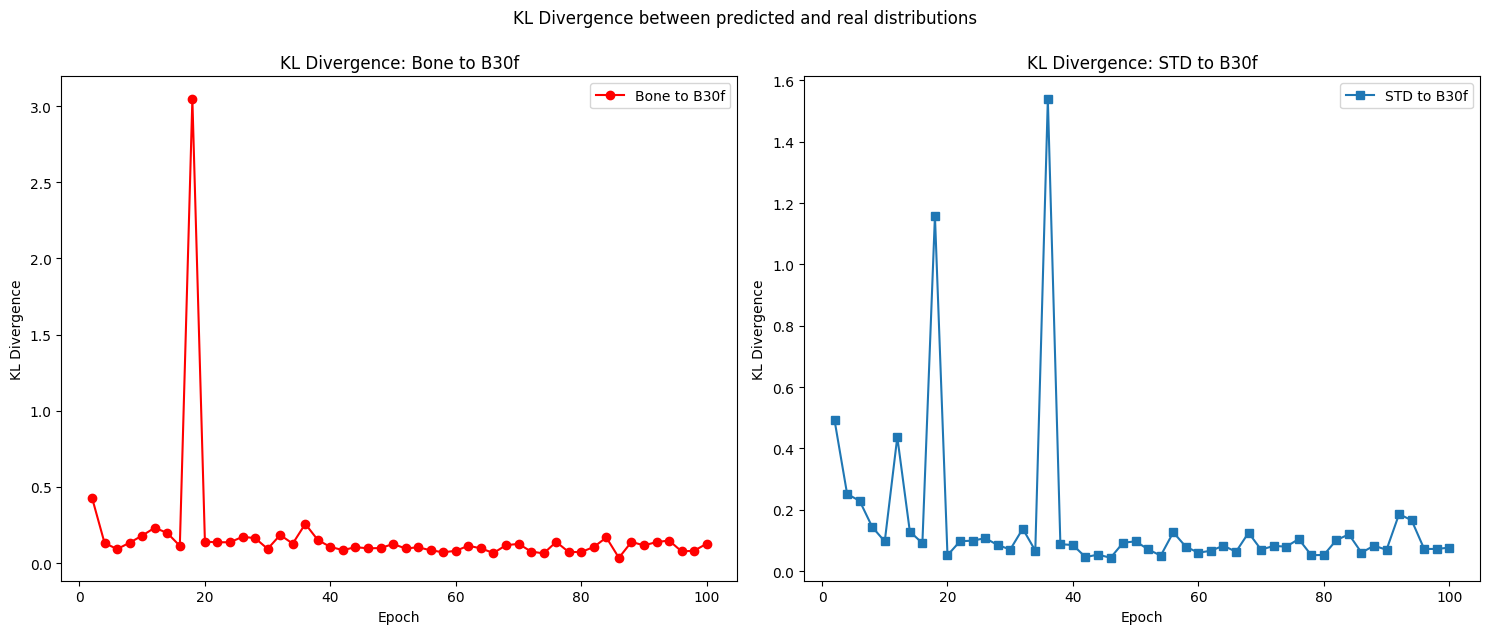

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(list(kl_bonetob30f.keys()), list(kl_bonetob30f.values()), label="BONE to B30f", marker='o', color='red')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("KL Divergence")
axes[0].legend()
axes[0].set_title("KL Divergence: Bone to B30f")

axes[1].plot(list(kl_stdtob30f.keys()), list(kl_stdtob30f.values()), label="STANDARD to B30f", marker='s')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("KL Divergence")
axes[1].legend()
axes[1].set_title("KL Divergence: STD to B30f")

plt.tight_layout()
plt.suptitle("KL Divergence between predicted and real distributions", y=1.05)
plt.show()

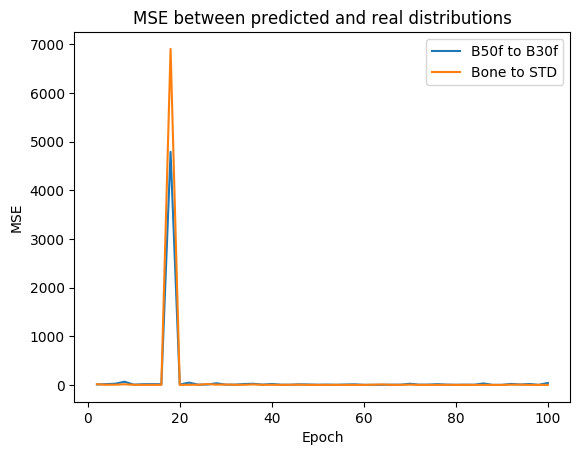

In [6]:
#Plot MSE
plt.figure()
plt.plot(list(mse_b50ftob30f.keys()), list(mse_b50ftob30f.values()), label = "B50f to B30f")
plt.plot(list(mse_bonetostd.keys()), list(mse_bonetostd.values()), label = "Bone to STD")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE between predicted and real distributions")
plt.show()

In [7]:
#Rank the values of the KL divergence and MSE
kl_bonetob30f_rank = rankdata(list(kl_bonetob30f.values()))
kl_stdtob30f_rank = rankdata(list(kl_stdtob30f.values()))
mse_b50ftob30f_rank = rankdata(list(mse_b50ftob30f.values()))
mse_bonetostd_rank = rankdata(list(mse_bonetostd.values()))

kl_bonetob30f_rank = {list(kl_bonetob30f.keys())[i]: kl_bonetob30f_rank[i] for i in range(len(kl_bonetob30f_rank))}
kl_stdtob30f_rank = {list(kl_stdtob30f.keys())[i]: kl_stdtob30f_rank[i] for i in range(len(kl_stdtob30f_rank))}
mse_b50ftob30f_rank = {list(mse_b50ftob30f.keys())[i]: mse_b50ftob30f_rank[i] for i in range(len(mse_b50ftob30f_rank))}
mse_bonetostd_rank = {list(mse_bonetostd.keys())[i]: mse_bonetostd_rank[i] for i in range(len(mse_bonetostd_rank))}

kl_bonetob30f_rank = dict(sorted(kl_bonetob30f_rank.items()))
kl_stdtob30f_rank = dict(sorted(kl_stdtob30f_rank.items()))
mse_b50ftob30f_rank = dict(sorted(mse_b50ftob30f_rank.items()))
mse_bonetostd_rank = dict(sorted(mse_bonetostd_rank.items()))

In [8]:
overall_rank = {}
for key in kl_bonetob30f_rank.keys():
    overall_rank[key] = kl_bonetob30f_rank[key] + kl_stdtob30f_rank[key] + mse_b50ftob30f_rank[key] + mse_bonetostd_rank[key]

overall_rank = dict(sorted(overall_rank.items()))
overall_rank

{2: 175.0,
 4: 148.0,
 6: 141.0,
 8: 170.0,
 10: 122.0,
 12: 142.0,
 14: 150.0,
 16: 106.0,
 18: 199.0,
 20: 86.0,
 22: 142.0,
 24: 119.0,
 26: 154.0,
 28: 155.0,
 30: 92.0,
 32: 139.0,
 34: 111.0,
 36: 186.0,
 38: 116.0,
 40: 119.0,
 42: 52.0,
 44: 71.0,
 46: 90.0,
 48: 97.0,
 50: 79.0,
 52: 60.0,
 54: 54.0,
 56: 92.0,
 58: 56.0,
 60: 42.0,
 62: 76.0,
 64: 91.0,
 66: 44.0,
 68: 102.0,
 70: 128.0,
 72: 55.0,
 74: 50.0,
 76: 114.0,
 78: 59.0,
 80: 21.0,
 82: 85.0,
 84: 99.0,
 86: 67.0,
 88: 64.0,
 90: 43.0,
 92: 158.0,
 94: 151.0,
 96: 72.0,
 98: 44.0,
 100: 112.0}

In [9]:
#Find epoch with the lowest overall rank
min_rank = min(overall_rank, key = overall_rank.get)
min_rank #epoch with lowest rank

80

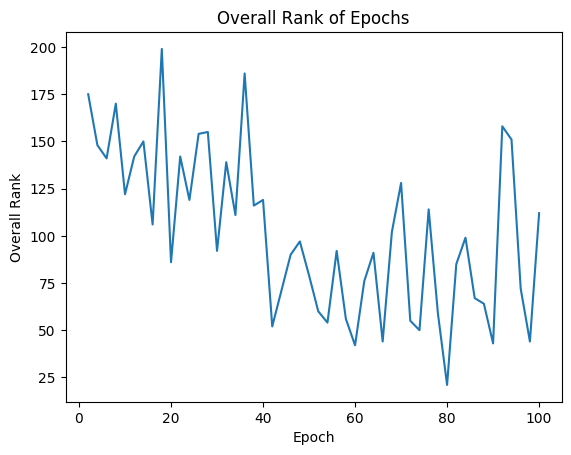

In [10]:
#Plot the overall rank
plt.figure()
plt.plot(list(overall_rank.keys()), list(overall_rank.values()))
plt.xlabel("Epoch")
plt.ylabel("Overall Rank")
plt.title("Overall Rank of Epochs")
plt.show()

In [11]:
#Epoch 42 emphysema scores
b50ftob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_80", "B50ftoB30f_emphysema", "emph.csv"))
b50ftob30f = b50ftob30f.sort_values(by = "pid")
bonetob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_80", "BONEtoB30f_emphysema", "emph.csv"))
bonetob30f = bonetob30f.sort_values(by = "pid")
stdtob30f = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_80", "STDtoB30f_emphysema", "emph.csv"))
stdtob30f = stdtob30f.sort_values(by = "pid")
bonetostd = pd.read_csv(os.path.join("/valiant02/masi/krishar1/MIDL_experiments/multipathgan_seg_identity_experiments_1-19-25/VALIDATION/MultipathGAN_with_context_seg_loss_only", "epoch_80", "BONEtoSTD_emphysema", "emph.csv"))
bonetostd = bonetostd.sort_values(by = "pid")

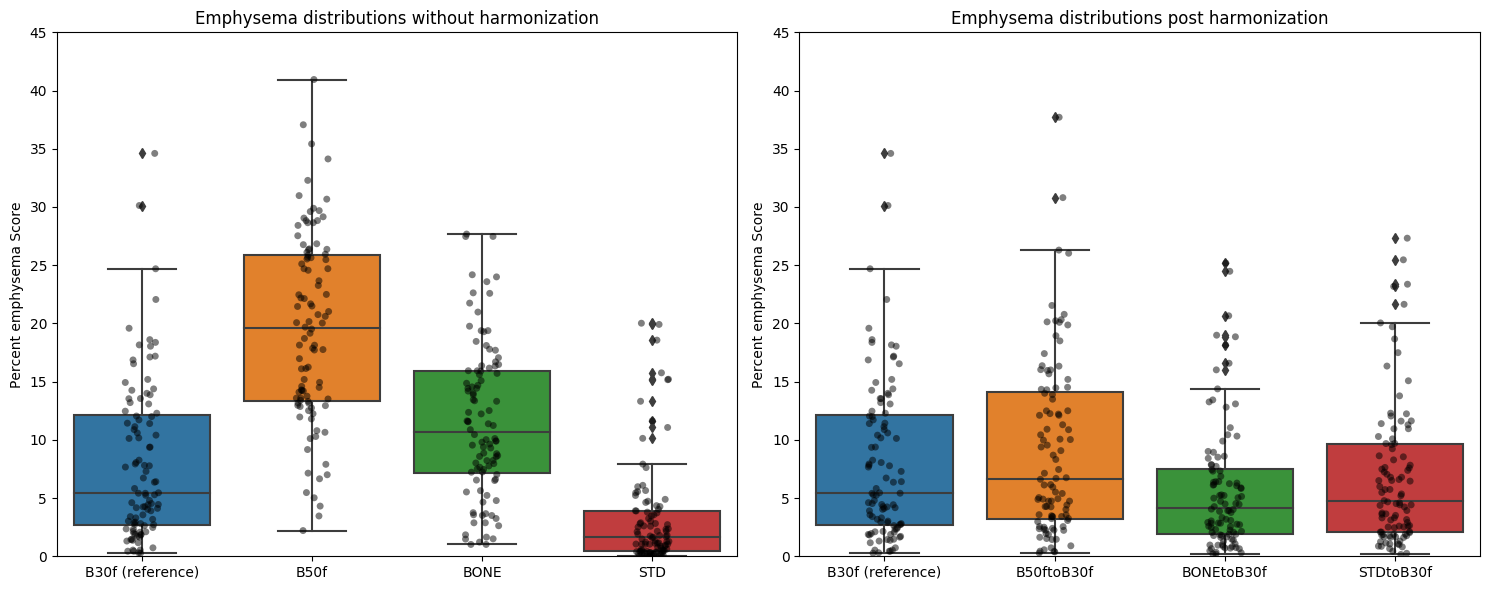

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=[b30f["emph_score"], b50f["emph_score"], bone["emph_score"], std["emph_score"]], ax=axes[0])
sns.stripplot(data=[b30f["emph_score"], b50f["emph_score"], bone["emph_score"], std["emph_score"]], ax=axes[0], color='black', alpha=0.5)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels(["B30f (reference)", "B50f", "BONE", "STD"])
axes[0].set_ylabel("Percent emphysema Score")
axes[0].set_title("Emphysema distributions without harmonization")
axes[0].set_ylim([0, 45])

sns.boxplot(data=[b30f["emph_score"], b50ftob30f["emph_score"], bonetob30f["emph_score"], stdtob30f["emph_score"]], ax=axes[1])
sns.stripplot(data=[b30f["emph_score"], b50ftob30f["emph_score"], bonetob30f["emph_score"], stdtob30f["emph_score"]], ax=axes[1], color='black', alpha=0.5)
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(["B30f (reference)", "B50ftoB30f", "BONEtoB30f", "STDtoB30f"])
axes[1].set_ylabel("Percent emphysema Score")
axes[1].set_title("Emphysema distributions post harmonization")
axes[1].set_ylim([0, 45])

plt.tight_layout()
plt.show()

In [87]:
#Paired data emphysema scores: Bland Altman analysis
def bland_altman_conversion_without_mean(hard, soft, converted,x_plot_range, y_plot_range):
    sd_limit = 1.96
    # annotation_font_size = 15
    annotation_font_size = 16

    fig, ax = plt.subplots(figsize=(10, 5), facecolor = "w")

    scatter_kwds = {'s': 20}
    mean_line_kwds = {}
    limit_lines_kwds = {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        # if 'color' not in kwds:
        #     kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 2


    diff_list_before = np.array(hard) - np.array(soft)

    mean_diff_before = np.mean(diff_list_before)
    std_diff_before = np.std(diff_list_before)

    diff_list_after = np.array(converted) - np.array(soft)

    mean_diff_after = np.mean(diff_list_after)
    std_diff_after = np.std(diff_list_after)
    
    plt.title("Agreement before and after kernel harmonization", fontsize = 18)

    ax.scatter(np.array(soft),diff_list_before, color='blue',s=10,alpha=0.5)
    ax.scatter(np.array(soft),diff_list_after, color='red',s=10,alpha=0.3)

    ax.set_ylim(y_plot_range[0], y_plot_range[1])
    ax.set_xlim(x_plot_range[0], x_plot_range[1])

    limit_of_agreement_before = sd_limit * std_diff_before
    lower_before = mean_diff_before - limit_of_agreement_before
    upper_before = mean_diff_before + limit_of_agreement_before 

    limit_of_agreement_after = sd_limit * std_diff_after
    lower_after = mean_diff_after - limit_of_agreement_after
    upper_after = mean_diff_after + limit_of_agreement_after 

    
    # for j, lim in enumerate([lower, upper]):
    ax.axhline(lower_before, linestyle='dotted', label=f'Before Conversion: -1.96 SD = {np.round(lower_before, 2)}',
               color='blue', alpha=0.5, **limit_lines_kwds)
    ax.axhline(upper_before, linestyle='dashed', label=f'Before Conversion: +1.96 SD = {np.round(upper_before, 2)}',
               color='blue', alpha=0.5, **limit_lines_kwds)
    ax.axhline(mean_diff_before, linestyle='solid', color='blue',
               label=f'Before Conversion: Mean Difference = {np.round(mean_diff_before, 2)}', alpha=0.5, **mean_line_kwds)
    

    ax.axhline(lower_after, linestyle='dotted', label=f'After Conversion: -1.96 SD = {np.round(lower_after, 2)}',
               color='red', alpha=0.5, **limit_lines_kwds)
    ax.axhline(upper_after, linestyle='dashed', label=f'After Conversion: +1.96 SD = {np.round(upper_after, 2)}',
               color='red', alpha=0.5, **limit_lines_kwds)
    ax.axhline(mean_diff_after, linestyle='solid', color='red',
               label=f'After Conversion: Mean Difference = {np.round(mean_diff_after, 2)}', alpha=0.5, **mean_line_kwds)

    ax.set_ylabel("Difference between measures of emphysema", fontsize=annotation_font_size)
    ax.set_xlabel("Ground truth emphysema measurement", fontsize=annotation_font_size)
    ax.tick_params(axis='x', labelsize=annotation_font_size)
    ax.tick_params(axis='y', labelsize=annotation_font_size)

    ax.legend(loc='best', fontsize=int(round(0.9 * annotation_font_size)))
    plt.gcf().set_dpi(300)
    # plt.savefig("bland_altman_emphysema.png", dpi = 300)
    plt.show() 

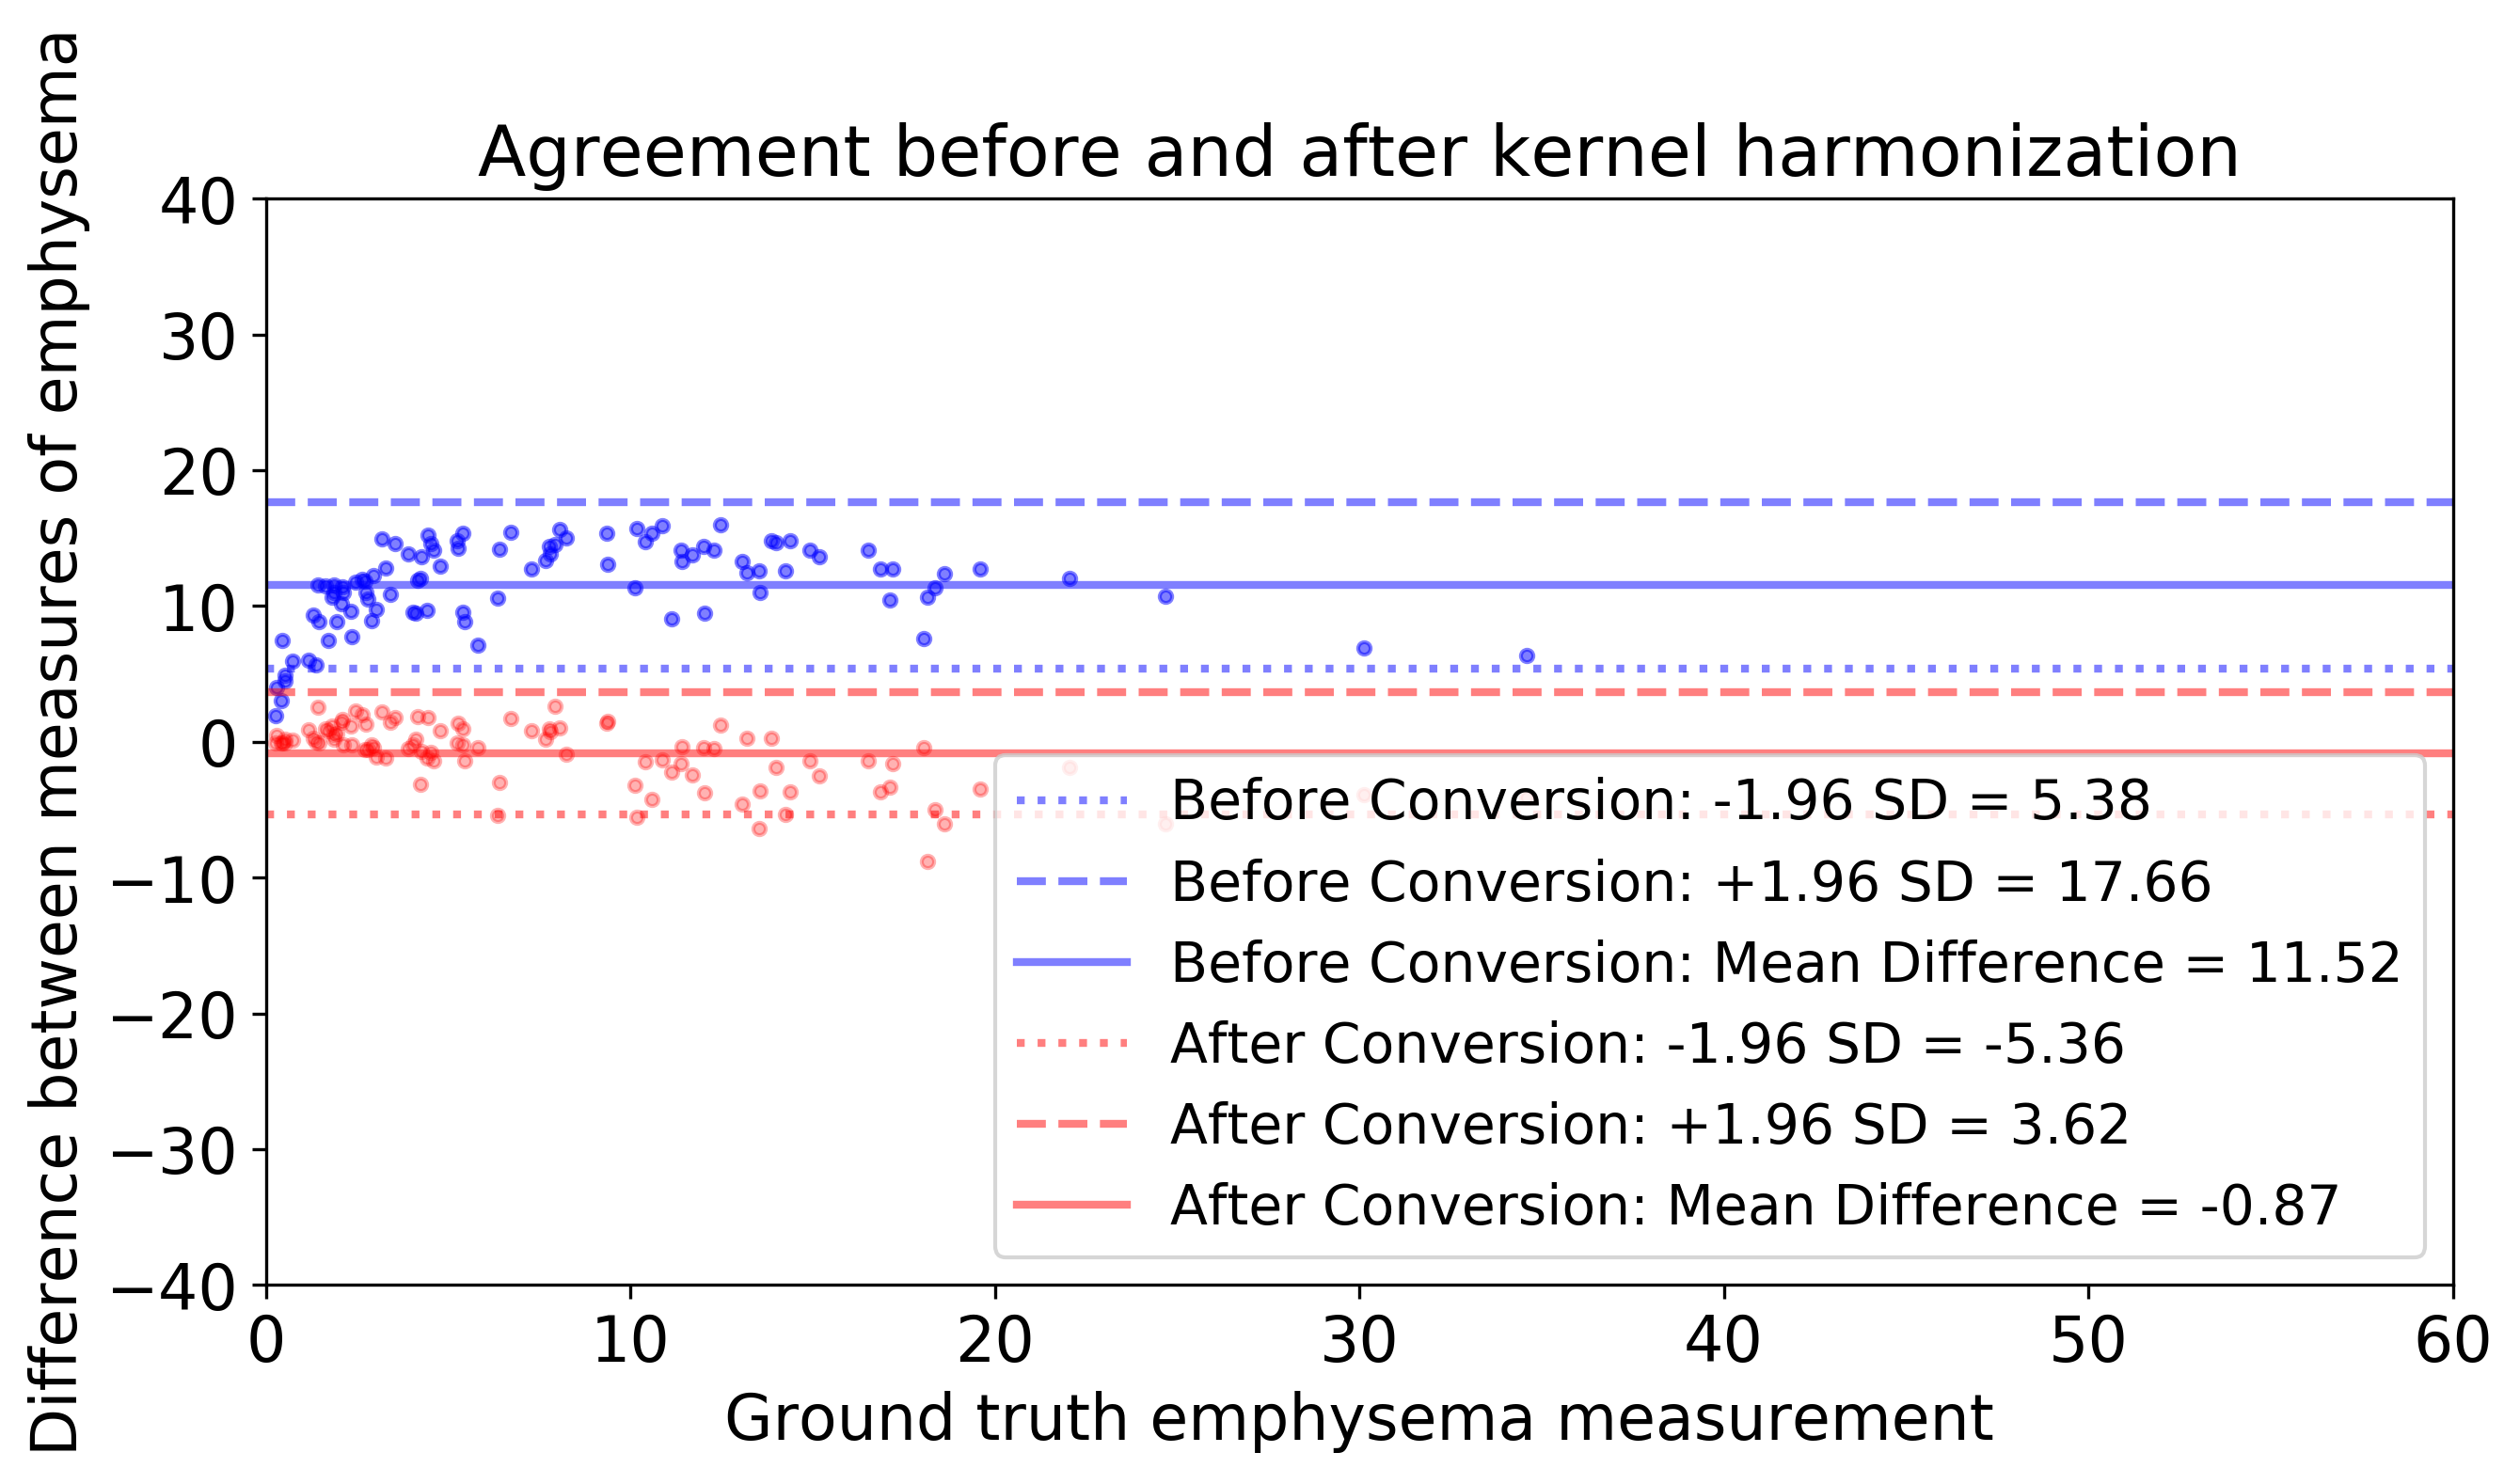

In [71]:
bland_altman_conversion_without_mean(b50f["emph_score"], b30f["emph_score"], b50ftob30f["emph_score"], [0, 60], [-40, 40])

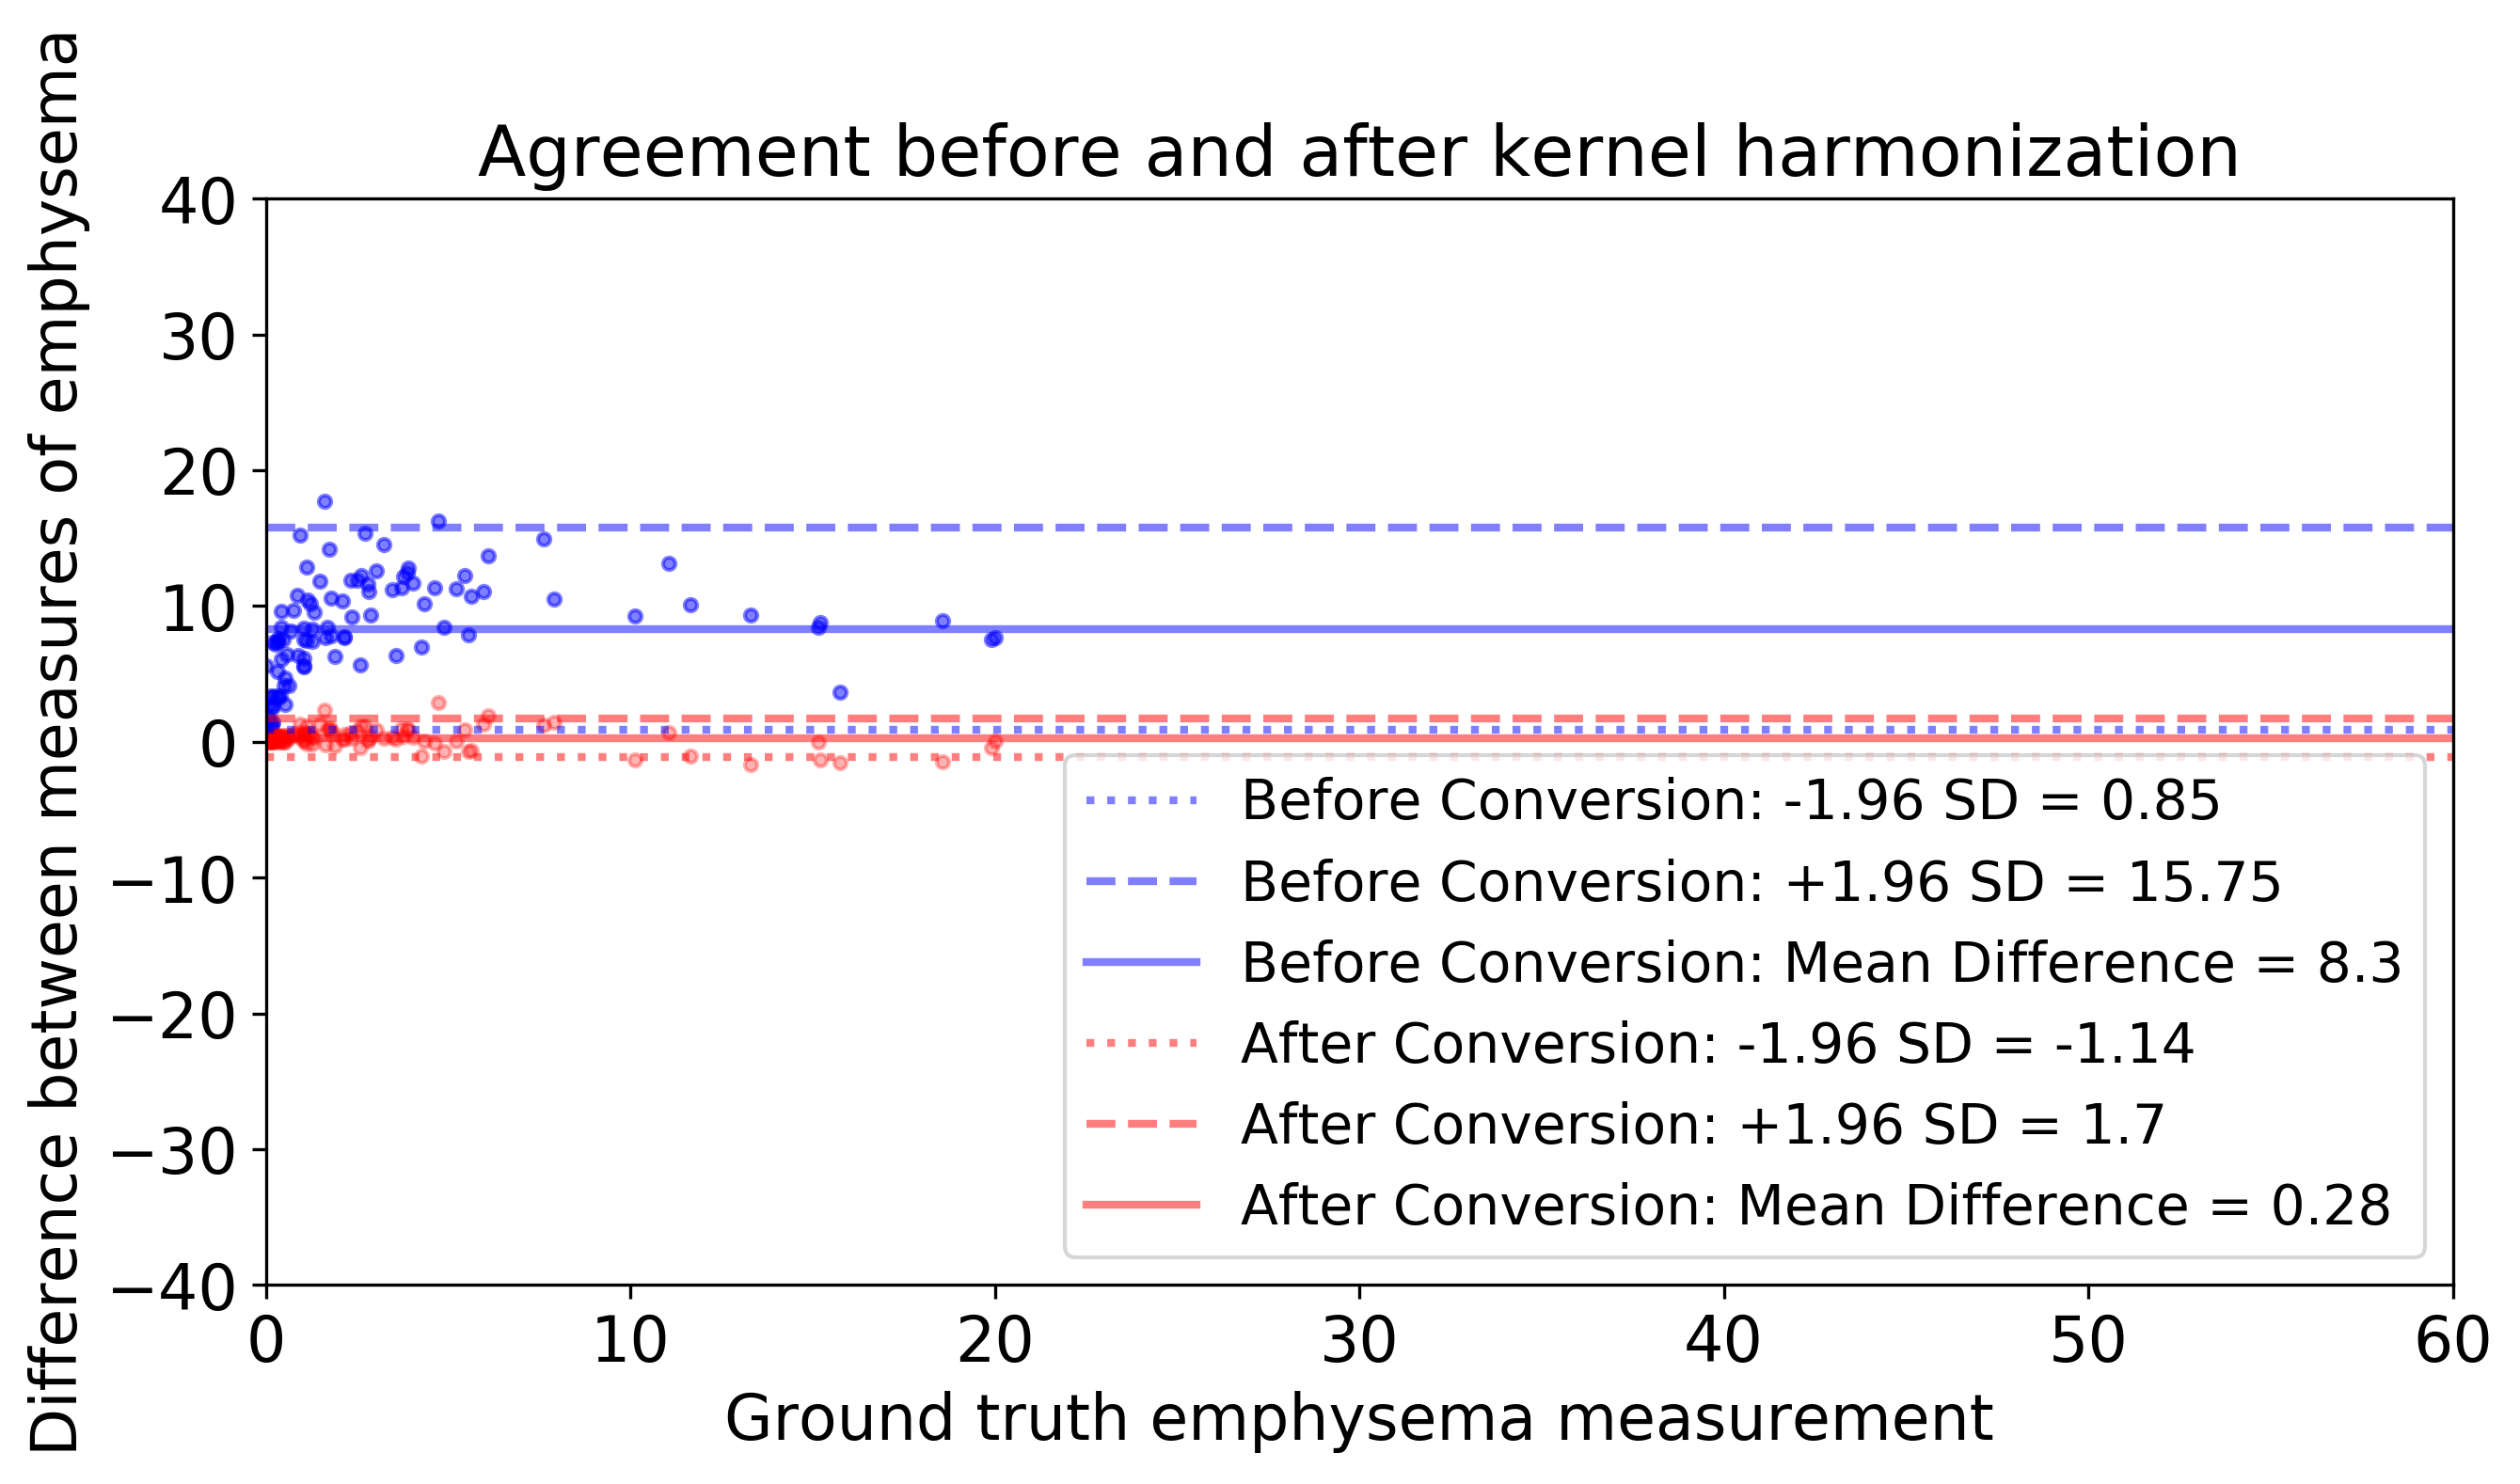

In [88]:
bland_altman_conversion_without_mean(bone["emph_score"], std["emph_score"], bonetostd["emph_score"], [0, 60], [-40, 40])